In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from bgspy.nb_utils import load_learnedfuncs_in_dir
from bgspy.learn_utils import fit_dnn
from bgspy.learn import LearnedFunction, LearnedB
from bgspy.plots import loss_limits_plot, bhat_plot

In [3]:
FIT_DIR = '../data/slim_sims/bmap_hg38/fits/'

res = load_learnedfuncs_in_dir(FIT_DIR)
res.keys()

2022-05-21 10:34:53.738764: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-21 10:34:56.525842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 485 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-05-21 10:34:56.527044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6120 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-05-21 10:34:56.528113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:

dict_keys([(0, 0, 0, 0, 4), (0, 0, 4, 2, 0), (0, 0, 0, 0, 2)])

In [4]:
y, X = res[(0, 0, 0, 0, 2)][0].func.y, res[(0, 0, 0, 0, 2)][0].func.X

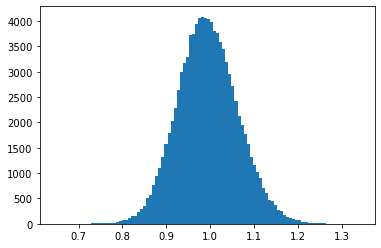

In [5]:
_ = plt.hist(y, 100)

In [6]:
class DownsampleTarget:
    def __init__(self, y, bins='fd', rng=None):
        self.y = y.squeeze()
        self.bins = bins
        self.hist, self.bin_edges = np.histogram(y, bins=bins)
        self.seed = rng if isinstance(rng, int) else None
        self.rng = np.random.default_rng(self.seed) if rng is None else rng

    def downsample(self, level, truncate=True, replace=False):
        bin_item_idx = np.digitize(self.y, self.bin_edges)
        bin_items = defaultdict(list)
        
        for i, idx in enumerate(bin_item_idx.tolist()):
            bin_items[idx].append(i)
        sample = []
        for vals in bin_items.values():
            if len(vals) <= level:
                if not truncate:
                    sample.extend(vals)
            else:
                sample.extend(self.rng.choice(vals, size=level, replace=replace).tolist())
        return np.array(sample)

    def fhat(self, x):
        x = x.squeeze()
        bin_edges = self.bin_edges
        bin_edges[-1] += 1e-6
        dens, _ = np.histogram(y, bins=self.bin_edges, density=True)
        idx = np.digitize(x, bin_edges)
        return dens[idx-1]/self.y.size
        
    def plot(self):
        return plt.bar(self.bin_edges[:-1], self.hist, width=np.diff(self.bin_edges)[0])
    

In [7]:
m = DownsampleTarget(y)
#plt.hist(m.downsample(level=100), bins=m.bin_edges)
idx = m.downsample(level=500)

In [74]:
len(m.bin_edges)

178

In [8]:
domain = {'mu': (-10, -7, True),
         'sh': (-5, -1, True),
         'L': (1, 10000, False),
         'rbp': (-12, -7, True),
         'rf': (-10, -0.824, True)}

In [9]:
func_full = LearnedFunction(X, y, domain=domain)
func_full.split()
func_full.scale_features()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - sh ∈ [-5, -1] (log10, <ufunc 'log10'>)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, <ufunc 'log10'>)
  - rf ∈ [-10, -0.824] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
Features normalized? True
Features split? True, test size: 20.0% (n=20,000)
Total size: 100,000

In [10]:
n = X.shape[0]
random_downsample = np.random.choice(np.arange(n), len(idx), replace=False)
func_rand = LearnedFunction(X[random_downsample, :], y[random_downsample, :], domain=domain)
func_rand.split()
func_rand.scale_features()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - sh ∈ [-5, -1] (log10, <ufunc 'log10'>)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, <ufunc 'log10'>)
  - rf ∈ [-10, -0.824] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
Features normalized? True
Features split? True, test size: 20.0% (n=6,000)
Total size: 30,000

(array([2.5000e+01, 2.6100e+02, 1.9370e+03, 6.9110e+03, 1.0302e+04,
        7.3090e+03, 2.6510e+03, 5.3000e+02, 7.1000e+01, 3.0000e+00]),
 array([0.7183481 , 0.77841705, 0.83848601, 0.89855497, 0.95862392,
        1.01869288, 1.07876183, 1.13883079, 1.19889975, 1.2589687 ,
        1.31903766]),
 <BarContainer object of 10 artists>)

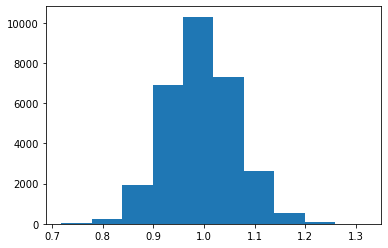

In [11]:
plt.hist(func_rand.y)

In [12]:
func = LearnedFunction(X[idx, :], y[idx, ], domain=domain)
func.split()
func.scale_features()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - sh ∈ [-5, -1] (log10, <ufunc 'log10'>)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, <ufunc 'log10'>)
  - rf ∈ [-10, -0.824] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
Features normalized? True
Features split? True, test size: 20.0% (n=6,000)
Total size: 30,000

(array([3000., 3000., 3000., 3000., 3000., 2999., 2999., 3002., 2999.,
        3001.]),
 array([0.87734744, 0.90084535, 0.92434327, 0.94784118, 0.97133909,
        0.99483701, 1.01833492, 1.04183283, 1.06533075, 1.08882866,
        1.11232658]),
 <BarContainer object of 10 artists>)

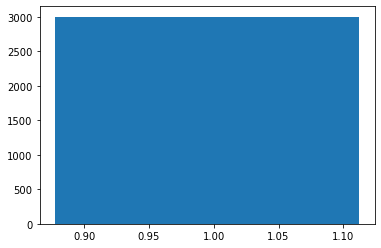

In [13]:
plt.hist(func.y)

In [82]:
%%time
model_sig, hist_sig = fit_dnn(func_full, n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='sigmoid')

Restoring model weights from the end of the best epoch: 253.
Epoch 00353: early stopping
CPU times: user 13min 54s, sys: 1min 19s, total: 15min 13s
Wall time: 9min 28s


In [14]:
%%time
model, hist = fit_dnn(func, n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='relu')

CPU times: user 6min 39s, sys: 50.6 s, total: 7min 29s
Wall time: 4min 15s


In [15]:
%%time
model_rand, hist_rand = fit_dnn(func_rand, n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='relu')

CPU times: user 6min 45s, sys: 51 s, total: 7min 36s
Wall time: 4min 17s


In [55]:
mfull = DownsampleTarget(y, 100)

sample_weight = mfull.fhat(y)

In [56]:
%%time
model_full, hist_full = fit_dnn(func_full, n128=0, n64=0, n32=0, n8=0, nx=4, 
                                sample_weight=1-sample_weight, output_activation='relu')

Restoring model weights from the end of the best epoch: 123.
Epoch 00223: early stopping
CPU times: user 14min 46s, sys: 1min 22s, total: 16min 8s
Wall time: 10min 3s


In [ ]:
%%time
model_relu, hist_relu = fit_dnn(func_full, n128=0, n64=0, n32=0, n8=0, nx=2, 
                                sample_weight=None, output_activation='relu')

(0.004, 0.005)

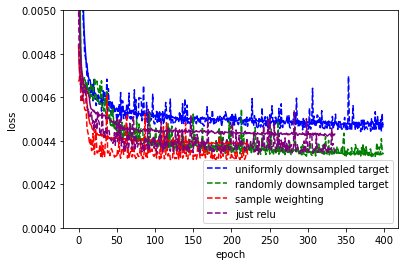

In [84]:
history = hist.history
history_sig = hist_sig.history
history_rand = hist_rand.history
history_full = hist_full.history
history_relu = hist_relu.history


plt.plot(history['loss'][1:], c='b')
plt.plot(history['val_loss'][1:], linestyle='dashed', c='b', label='uniformly downsampled target')

plt.plot(history_rand['loss'][1:], c='g')
plt.plot(history_rand['val_loss'][1:], linestyle='dashed', c='g', label='randomly downsampled target')

plt.plot(history_full['loss'][1:], c='r')
plt.plot(history_full['val_loss'][1:], linestyle='dashed', c='r', label='sample weighting')

plt.plot(history_relu['loss'][1:], c='purple')
plt.plot(history_relu['val_loss'][1:], linestyle='dashed', c='purple', label='just relu')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0.004, 0.005)

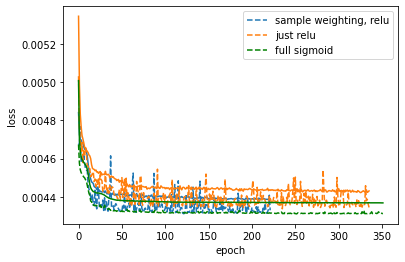

In [90]:
line = plt.plot(history_full['loss'][1:])
plt.plot(history_full['val_loss'][1:], linestyle='dashed', c=line[0].get_color(), label='sample weighting, relu')

plt.xlabel('epoch')
plt.ylabel('loss')

line = plt.plot(history_relu['loss'][1:])
plt.plot(history_relu['val_loss'][1:], linestyle='dashed', c=line[0].get_color(), label='just relu')

plt.xlabel('epoch')
plt.ylabel('loss')


plt.plot(history_sig['loss'][1:], c='g')
plt.plot(history_sig['val_loss'][1:], linestyle='dashed', c='g', label='full sigmoid')
plt.legend()

Text(0, 0.5, 'loss')

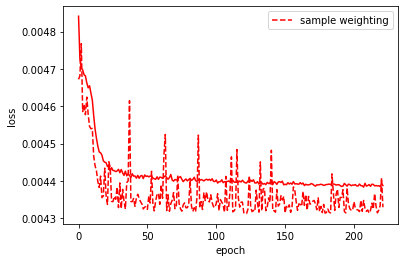

In [64]:


plt.plot(history_full['loss'][1:], c='r')
plt.plot(history_full['val_loss'][1:], linestyle='dashed', c='r', label='sample weighting')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

In [65]:
func.model = model
func_rand.model = model_rand
func_full.model = model_full

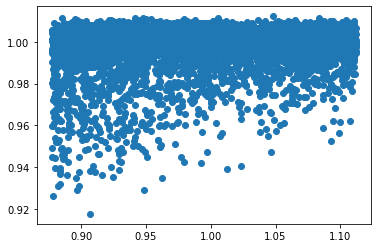

In [66]:
plt.scatter(func.y_test, func.predict_test())

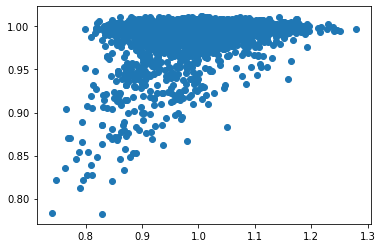

In [67]:
plt.scatter(func_rand.y_test, func_rand.predict_test())

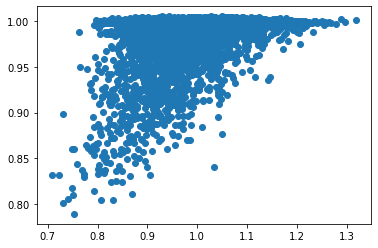

In [68]:
plt.scatter(func_full.y_test, func_full.predict_test())

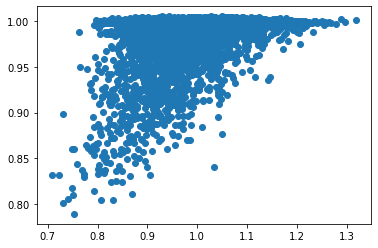

In [69]:
plt.scatter(func_full.y_test, func_full.predict_test())

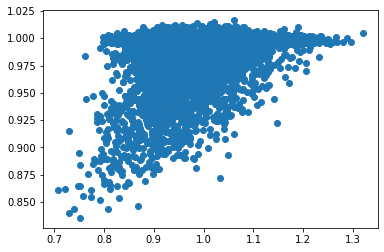

In [70]:
func_full.model = model_relu
plt.scatter(func_full.y_test, func_full.predict_test())

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>)

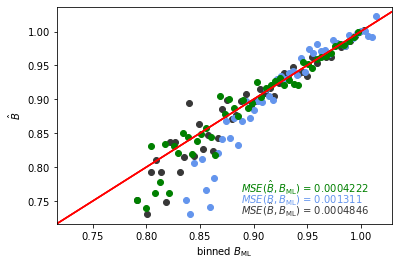

In [91]:
n = 50

figax = plt.subplots()

func_full.model = model_full
bfunc = LearnedB()
bfunc.func = func_full
figax = bhat_plot(bfunc, n, figax=figax)

func_full.model = model_relu
bfunc = LearnedB()
bfunc.func = func_full
bhat_plot(bfunc, n, figax=figax, label_pos=(0.55, 0.1), c='cornflowerblue')


func_full.model = model_sig
bfunc = LearnedB()
bfunc.func = func_full
bhat_plot(bfunc, n, figax=figax, label_pos=(0.55, 0.15), c='g')

In [ ]:
k